# Load Packages

In [4]:
# Set to use legacy Keras API
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Install tf-keras (compatibility layer)
!pip install tf-keras

# Import packages
import tensorflow as tf

# Disable JIT/XLA compilation
tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(True)

import numpy as np
import pandas as pd
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

# Install other dependencies (using Keras 3 compatible segmentation-models)
!pip install rarfile rioxarray
!pip install git+https://github.com/qubvel/segmentation_models.git

from rarfile import RarFile
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from tensorflow.keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Compatibility: create alias for adam_v2
from tensorflow.keras import optimizers as adam_v2

  Using cached rarfile-4.2-py3-none-any.whl.metadata (4.4 kB)
  Using cached rioxarray-0.20.0-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00
  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-2md5ytwh
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-2md5ytwh
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Using cached Keras_Applications-1.0.8-py3-none-any.whl.metadata (1.7 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.8 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=8c79f82baf6f16392

In [5]:
# Specify whether to download data or read in
download = True
base_dir = r"./Amazon Forest Dataset/"

In [6]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

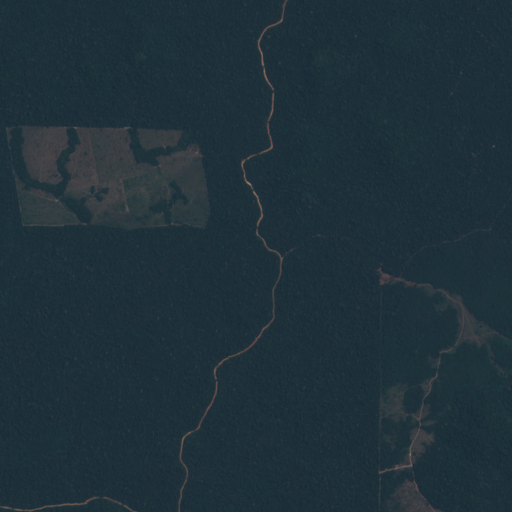

In [7]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [9]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [10]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [11]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process RGB Dataset

In [12]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [13]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [14]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [15]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):

    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed)

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img,mask) in train_generator:
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [16]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [17]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [18]:
# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [19]:
# Ingest images and normalise

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

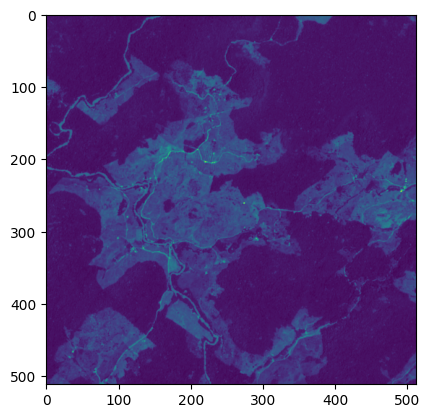

In [20]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [21]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [22]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

In [23]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [24]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [25]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [26]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

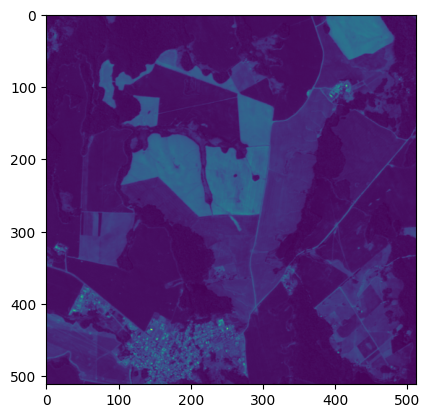

In [27]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [28]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [29]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [30]:
# Print model layers and number of parameters
UNet().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (1, 512, 512, 64) │      1,792 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (1, 512, 512, 64) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (1, 512, 512, 64) │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (1, 512, 512, 64) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (1, 256, 256, 64) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (1, 256, 256,     │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (1, 256, 256,     │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (1, 256, 256,     │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (1, 256, 256,     │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (1, 128, 128,     │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (1, 128, 128,     │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (1, 128, 128,     │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (1, 128, 128,     │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (1, 128, 128,     │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (1, 64, 64, 256)  │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (1, 64, 64, 512)  │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (1, 64, 64, 512)  │          0 │ conv2d_6[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Attention U-Net

In [35]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv

'''
  Attention block/mechanism
'''
'''
  Attention block/mechanism (fixed version)
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):

    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Calculate the downsampling ratio for x to match gating's spatial dimensions
    strides = (shape_x[1] // shape_g[1], shape_x[2] // shape_g[2])

    # x vector input - use strides to match gating's spatial size
    theta_x = Conv2D(inter_shape, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal')(x)

    # gating signal
    phi_g = Conv2D(inter_shape, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(gating)

    # Add components (shapes now match)
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)

    # UpSample back to original x size
    upsample_psi = UpSampling2D(size=strides, interpolation='bilinear')(sigmoid_xg)

    # Ensure shapes match exactly (handle edge cases)
    upsample_psi = Lambda(lambda t: tf.image.resize(t, [shape_x[1], shape_x[2]]))(upsample_psi)

    # Multiply with original x
    y = multiply([upsample_psi, x])

    return y

'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    # model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    # 修改后：去掉前面的 'adam_v2.'，直接用 Adam
    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [36]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (1, 512, 512, 16) │        448 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (1, 512, 512, 16) │          0 │ conv2d_45[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (1, 512, 512, 16) │      2,320 │ activation_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (1, 512, 512, 16) │          0 │ conv2d_46[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (1, 256, 256, 16) │          0 │ activation_44[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (1, 256, 256, 32) │          0 │ conv2d_47[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (1, 256, 256, 32) │      9,248 │ activation_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (1, 256, 256, 32) │          0 │ conv2d_48[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (1, 128, 128, 32) │          0 │ activation_46[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (1, 128, 128, 64) │          0 │ conv2d_49[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (1, 128, 128, 64) │     36,928 │ activation_47[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (1, 128, 128, 64) │          0 │ conv2d_50[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (1, 64, 64, 64)   │          0 │ activation_48[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (1, 64, 64, 128)  │          0 │ conv2d_51[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (1, 64, 64, 128)  │    147,584 │ activation_49[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

## ResNet50-SegNet

In [37]:
'''
  SegNet Contraction Phase Block
'''
def resnetConvDownBlock(x, filter, kernel, act='relu'):
    for i in range(3):
        x = ZeroPadding2D((1,1))(x)
        x = Conv2D(filters=filter, kernel_size=kernel, kernel_initializer='he_normal')(x)
        x = Activation('relu')(x)
    return x

'''
  SegNet Expansion Phase Block
'''
def resnetConvUpBlock(x, skip_connection=None, filter=None, kernel=None, use_skip=False):
    out = UpSampling2D((2,2))(x)

    for i in range(3):
        out = ZeroPadding2D((1,1))(out)
        out = Conv2D(filters=filter, kernel_size=kernel, kernel_initializer='he_normal')(out)
        out = Activation('relu')(out)

    if use_skip:
        out = Add()([out, skip_connection])
    return out

'''
  ResNet50-SegNet Model (simplified version - no MaxPoolWithArgmax)
'''
def ResNet50SegNet(input_size=(512,512,3), lr=0.0001, filters=64, kernel_sz=3):
    inputs = Input(input_size)

    # Encoder
    block1 = resnetConvDownBlock(inputs, filter=filters, kernel=kernel_sz)
    pool1 = MaxPooling2D((2,2))(block1)

    block2 = resnetConvDownBlock(pool1, filter=2*filters, kernel=kernel_sz)
    pool2 = MaxPooling2D((2,2))(block2)

    block3 = resnetConvDownBlock(pool2, filter=4*filters, kernel=kernel_sz)
    pool3 = MaxPooling2D((2,2))(block3)

    block4 = resnetConvDownBlock(pool3, filter=8*filters, kernel=kernel_sz)
    pool4 = MaxPooling2D((2,2))(block4)

    block5 = resnetConvDownBlock(pool4, filter=16*filters, kernel=kernel_sz)
    pool5 = MaxPooling2D((2,2))(block5)

    # Decoder
    block5_ = resnetConvUpBlock(pool5, filter=16*filters, kernel=kernel_sz, use_skip=False)
    block4_ = resnetConvUpBlock(block5_, skip_connection=block4, filter=8*filters, kernel=kernel_sz, use_skip=True)
    block3_ = resnetConvUpBlock(block4_, skip_connection=block3, filter=4*filters, kernel=kernel_sz, use_skip=True)
    block2_ = resnetConvUpBlock(block3_, skip_connection=block2, filter=2*filters, kernel=kernel_sz, use_skip=True)
    block1_ = resnetConvUpBlock(block2_, skip_connection=block1, filter=filters, kernel=kernel_sz, use_skip=True)

    # Output
    outputs = Conv2D(1, kernel_size=1, strides=1, kernel_initializer='he_normal')(block1_)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss=binary_crossentropy, metrics=['accuracy', 'mse'])
    return model

In [38]:
# Print model layers and number of parameters
ResNet50SegNet().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 514, 514,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 512, 512,  │      1,792 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_70       │ (None, 512, 512,  │          0 │ conv2d_76[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 514, 514,  │          0 │ activation_70[0]… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 512, 512,  │     36,928 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_71       │ (None, 512, 512,  │          0 │ conv2d_77[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 514, 514,  │          0 │ activation_71[0]… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 512, 512,  │     36,928 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 512, 512,  │          0 │ conv2d_78[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 256, 256,  │          0 │ activation_72[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 258, 258,  │          0 │ max_pooling2d_18… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 256, 256,  │     73,856 │ zero_padding2d_3… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 256, 256,  │          0 │ conv2d_79[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 258, 258,  │          0 │ activation_73[0]… │
│ (ZeroPadding2D)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 256, 256,  │    147,584 │ zero_padding2d_4… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 256, 256,  │          0 │ conv2d_80[0][0] 

 Total params: 72,267,137 (275.68 MB)

 Trainable params: 72,267,137 (275.68 MB)

 Non-trainable params: 0 (0.00 B)

## FCN32-VGG16

In [39]:
# Code forked and modified from: https://github.com/divamgupta/image-segmentation-keras

'''
  FCN32-VGG16 model
'''

def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    # Input
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    ## Encoder
    # Block 1
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    # Decoder
    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)
    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="output"))(o)

    # Output
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [40]:
# Print model layers and number of parameters
fcn_32().summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 512, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_102 (Activation)     │ (None, 512, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_103 (Activation)     │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_104 (Activation)     │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_107 (Activation)     │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 64, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_108 (Activation)     │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_109 (Activation)     │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_110 (Activation)     │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 32, 32, 512)    │             

 Total params: 134,268,740 (512.19 MB)

 Trainable params: 134,268,740 (512.19 MB)

 Non-trainable params: 0 (0.00 B)

## ResUNet

In [41]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.Conv2D(filters=num_filters[0],
                                kernel_size=kernel_size,
                                strides=strides[0],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1],
                                kernel_size=kernel_size,
                                strides=strides[1],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and
    final convolution. The input is then put through
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    #x1 = tf.keras.layers.BatchNormalization()(x)
    #x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Activation('relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0],
                                kernel_size=kernel_size,
                                strides=strides[0],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1],
                                kernel_size=kernel_size,
                                strides=strides[1],
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function
    in detail. Original Unet uses a transpose convolution that downsamples
    the number of feature maps. In order to restrict the number of
    parameters here we use a bilinear resampling layer. This results in
    the concatentation layer concatenting feature maps with n and n/2
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized

def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size,
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes,
                                    kernel_size,
                                    strides=1,
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [42]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_1 (Conv2D)   │ (None, 512, 512,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_117      │ (None, 512, 512,  │          0 │ layer1_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_shortcut     │ (None, 512, 512,  │        256 │ input_layer_6[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_2 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation_117[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 512, 512,  │          0 │ layer1_shortcut[… │
│                     │ 64)               │            │ layer1_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_118      │ (None, 512, 512,  │          0 │ add_10[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer1_1    │ (None, 256, 256,  │     73,856 │ activation_118[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_119      │ (None, 256, 256,  │          0 │ encoder_layer1_1… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer1_sho… │ (None, 256, 256,  │      8,320 │ add_10[0][0]      │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer1_2    │ (None, 256, 256,  │    147,584 │ activation_119[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 256, 256,  │          0 │ encoder_layer1_s… │
│                     │ 128)              │            │ encoder_layer1_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 256, 256,  │          0 │ add_11[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer2_1    │ (None, 128, 128,  │    295,168 │ activation_120[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (None, 128, 128,  │          0 │ encoder_layer2_1… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer2_sho… │ (None, 128, 128,  │     33,024 │ add_11[0][0]      │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer2_2    │ (None, 128, 128,  │    590,080 │ activation_121[0

 Total params: 33,123,393 (126.36 MB)

 Trainable params: 33,123,393 (126.36 MB)

 Non-trainable params: 0 (0.00 B)

# Train on RGB feature data

## U-Net

In [43]:
# Train U-Net with generator
model_unet = UNet(input_size=(512, 512, 3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data=validation_df, callbacks=[save_model])

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6563 - loss: 0.5665 - mse: 0.1952
Epoch 1: val_accuracy improved from -inf to 0.91663, saving model to unet-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 315ms/step - accuracy: 0.6576 - loss: 0.5650 - mse: 0.1947 - val_accuracy: 0.9166 - val_loss: 0.2151 - val_mse: 0.0630
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9284 - loss: 0.2069 - mse: 0.0571
Epoch 2: val_accuracy did not improve from 0.91663
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.9283 - loss: 0.2070 - mse: 0.0571 - val_accuracy: 0.8994 - val_loss: 0.2685 - val_mse: 0.0781
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9329 - loss: 0.1848 - mse: 0.0518
Epoch 3: val_accuracy improved from 0.91663 to 0.92503, saving model to unet-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.9328 - loss: 0.1849 - mse: 0.0519 - val_accuracy: 0.9250 - val_loss: 0.1945 - val_mse: 0.0565
Epoch 4/30
100/100 ━━━━━━━━━━

In [44]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

In [45]:
# Copy models to drive
!cp unet-3d.hdf5 drive/MyDrive/Diss/
!cp unet-3d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-3d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


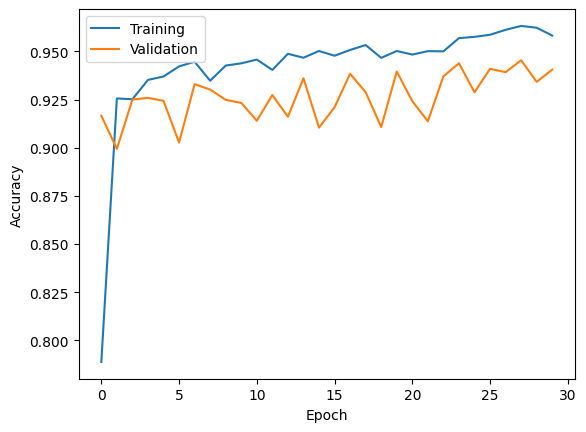

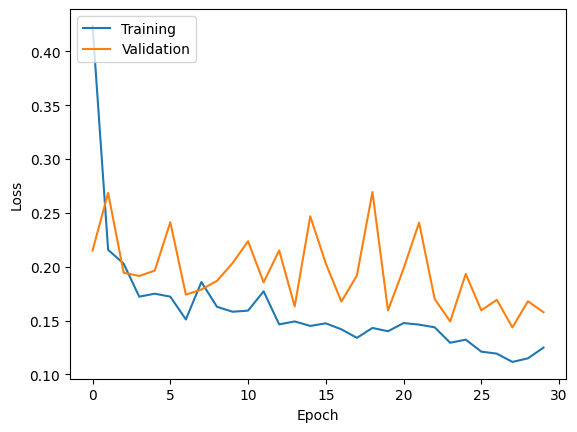

In [46]:
# Plot accuracy and loss

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [47]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data=validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5733 - loss: 0.7364 - mse: 0.2669
Epoch 1: val_accuracy improved from -inf to 0.88248, saving model to unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.5743 - loss: 0.7354 - mse: 0.2665 - val_accuracy: 0.8825 - val_loss: 0.2951 - val_mse: 0.0883
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8979 - loss: 0.2742 - mse: 0.0784
Epoch 2: val_accuracy improved from 0.88248 to 0.90923, saving model to unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.8979 - loss: 0.2742 - mse: 0.0784 - val_accuracy: 0.9092 - val_loss: 0.2394 - val_mse: 0.0701
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9274 - loss: 0.2071 - mse: 0.0565
Epoch 3: val_accuracy did not improve from 0.90923
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.9273 - loss: 0.2073 - mse: 0.0566 - val_accuracy: 0.8747 - val_loss: 0.3121 - val_mse: 0.096

In [48]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

In [49]:
# Copy models to drive
!cp unet-attention-3d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-3d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-attention-3d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


## ResNet50-SegNet

In [51]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data=validation_df, epochs=40, steps_per_epoch=100, callbacks=[save_model_resnet])

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6390 - loss: 1.4090 - mse: 0.2309
Epoch 1: val_accuracy improved from -inf to 0.64953, saving model to resnet50segnet-3d.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 498ms/step - accuracy: 0.6402 - loss: 1.4022 - mse: 0.2303 - val_accuracy: 0.6495 - val_loss: 0.5987 - val_mse: 0.2105
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8985 - loss: 0.3064 - mse: 0.0863
Epoch 2: val_accuracy improved from 0.64953 to 0.90971, saving model to resnet50segnet-3d.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 511ms/step - accuracy: 0.8986 - loss: 0.3062 - mse: 0.0862 - val_accuracy: 0.9097 - val_loss: 0.2318 - val_mse: 0.0674
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9272 - loss: 0.2139 - mse: 0.0588
Epoch 3: val_accuracy did not improve from 0.90971
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 481ms/step - accuracy: 0.9272 - loss: 0.2140 - mse: 0.0589 - val_accuracy: 0.8817 - val_loss: 0.2989 - val_

In [52]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

In [53]:
# Copy models to drive
!cp resnet50segnet-3d.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-3d-history.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resnet50segnet-3d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


## FCN32-VGG16

In [55]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4961 - loss: 0.6931 - mse: 0.2500
Epoch 1: val_accuracy improved from -inf to 0.48243, saving model to fcn32-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 292ms/step - accuracy: 0.4964 - loss: 0.6931 - mse: 0.2500 - val_accuracy: 0.4824 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5579 - loss: 0.6930 - mse: 0.2499
Epoch 2: val_accuracy did not improve from 0.48243
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.5579 - loss: 0.6930 - mse: 0.2499 - val_accuracy: 0.4813 - val_loss: 0.6933 - val_mse: 0.2501
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5485 - loss: 0.6928 - mse: 0.2498
Epoch 3: val_accuracy improved from 0.48243 to 0.48783, saving model to fcn32-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 303ms/step - accuracy: 0.5485 - loss: 0.6928 - mse: 0.2498 - val_accuracy: 0.4878 - val_loss: 0.6976 - val_mse: 0.2522
Epoch 4/50
100/1

In [56]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

In [57]:
# Copy models to drive
!cp fcn32-3d.hdf5 drive/MyDrive/Diss/
!cp fcn32-3d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'fcn32-3d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


## ResUNet

In [58]:
R = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
save_model_resunet = ModelCheckpoint('resunet-3d.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resunet])

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7018 - loss: 25.5976 - mse: 0.2779
Epoch 1: val_accuracy improved from -inf to 0.89314, saving model to resunet-3d.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - accuracy: 0.7028 - loss: 25.4225 - mse: 0.2770 - val_accuracy: 0.8931 - val_loss: 0.3380 - val_mse: 0.0850
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8870 - loss: 0.4159 - mse: 0.0925
Epoch 2: val_accuracy improved from 0.89314 to 0.91790, saving model to resunet-3d.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.8871 - loss: 0.4153 - mse: 0.0924 - val_accuracy: 0.9179 - val_loss: 0.2266 - val_mse: 0.0640
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9339 - loss: 0.1912 - mse: 0.0519
Epoch 3: val_accuracy did not improve from 0.91790
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.9338 - loss: 0.1916 - mse: 0.0519 - val_accuracy: 0.8922 - val_loss: 0.3036 - val_mse: 0.0837


In [59]:
# Save model history
np.save('resunet-3d-history.npy',R.history.history)

In [60]:
# Copy models to drive
!cp resunet-3d.hdf5 drive/MyDrive/Diss/models/
!cp resunet-3d-history.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resunet-3d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [63]:
# Train U-Net with generator
model_unet_4band = UNet(input_size=(512, 512, 4))
save_model_4band = ModelCheckpoint('unet-4d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7978 - loss: 0.4343 - mse: 0.1409
Epoch 1: val_accuracy improved from -inf to 0.92917, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.7981 - loss: 0.4339 - mse: 0.1407 - val_accuracy: 0.9292 - val_loss: 0.2022 - val_mse: 0.0565
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9360 - loss: 0.1749 - mse: 0.0491
Epoch 2: val_accuracy improved from 0.92917 to 0.95081, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.9360 - loss: 0.1749 - mse: 0.0491 - val_accuracy: 0.9508 - val_loss: 0.1340 - val_mse: 0.0376
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9494 - loss: 0.1340 - mse: 0.0382
Epoch 3: val_accuracy improved from 0.95081 to 0.95203, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 316ms/step - accuracy: 0.9493 - loss: 0.1341 - mse: 0.0382 - val_accuracy: 0.9520 - val_loss: 0.1286 -

In [64]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [65]:
# Copy models to drive
!cp unet-4d.hdf5 drive/MyDrive/Diss/
!cp unet-4d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-4d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### Attention U-Net

In [66]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7137 - loss: 0.5891 - mse: 0.2055
Epoch 1: val_accuracy improved from -inf to 0.88950, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 422ms/step - accuracy: 0.7141 - loss: 0.5885 - mse: 0.2053 - val_accuracy: 0.8895 - val_loss: 0.2958 - val_mse: 0.0873
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9160 - loss: 0.2289 - mse: 0.0648
Epoch 2: val_accuracy improved from 0.88950 to 0.90928, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 421ms/step - accuracy: 0.9160 - loss: 0.2289 - mse: 0.0649 - val_accuracy: 0.9093 - val_loss: 0.2432 - val_mse: 0.0712
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9277 - loss: 0.1926 - mse: 0.0550
Epoch 3: val_accuracy improved from 0.90928 to 0.92421, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 423ms/step - accuracy: 0.9277 - loss: 0.1926 - mse: 0.0550 - val_accu

In [67]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [68]:
# Copy models to drive
!cp unet-attention-4d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-attention-4d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### ResNet50-SegNet

In [69]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7608 - loss: 0.5588 - mse: 0.1829
Epoch 1: val_accuracy improved from -inf to 0.92145, saving model to resnet50segnet-4d.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 514ms/step - accuracy: 0.7611 - loss: 0.5582 - mse: 0.1827 - val_accuracy: 0.9214 - val_loss: 0.2331 - val_mse: 0.0657
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9287 - loss: 0.1922 - mse: 0.0545
Epoch 2: val_accuracy improved from 0.92145 to 0.93951, saving model to resnet50segnet-4d.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.9287 - loss: 0.1923 - mse: 0.0545 - val_accuracy: 0.9395 - val_loss: 0.1630 - val_mse: 0.0462
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9412 - loss: 0.1712 - mse: 0.0443
Epoch 3: val_accuracy did not improve from 0.93951
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.9411 - loss: 0.1715 - mse: 0.0444 - val_accuracy: 0.9292 - val_loss: 0.2008 - v

In [70]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

In [71]:
# Copy models to drive
!cp resnet50segnet-4d.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-4d-history.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resnet50segnet-4d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


### FCN32-VGG16

In [72]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 50, callbacks=[save_model_fcn_4band])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5403 - loss: 0.6930 - mse: 0.2499
Epoch 1: val_accuracy improved from -inf to 0.49898, saving model to fcn32-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.5402 - loss: 0.6930 - mse: 0.2499 - val_accuracy: 0.4990 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5493 - loss: 0.6909 - mse: 0.2479
Epoch 2: val_accuracy improved from 0.49898 to 0.52915, saving model to fcn32-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 269ms/step - accuracy: 0.5492 - loss: 0.6909 - mse: 0.2479 - val_accuracy: 0.5291 - val_loss: 0.6918 - val_mse: 0.2493
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6095 - loss: 0.6939 - mse: 0.2465
Epoch 3: val_accuracy improved from 0.52915 to 0.66287, saving model to fcn32-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 266ms/step - accuracy: 0.6093 - loss: 0.6939 - mse: 0.2466 - val_accuracy: 0.6629 - val_loss: 0.691

In [73]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

In [74]:
# Copy models to drive
!cp fcn32-4d.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-history.npy drive/MyDrive/Diss/

cp: cannot stat 'fcn32-4d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### ResUNet

In [75]:
R_4band = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band = ModelCheckpoint('resunet-4d.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resunet_4band])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8128 - loss: 4.6310 - mse: 0.1677
Epoch 1: val_accuracy improved from -inf to 0.90831, saving model to resunet-4d.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - accuracy: 0.8130 - loss: 4.6183 - mse: 0.1675 - val_accuracy: 0.9083 - val_loss: 0.2469 - val_mse: 0.0697
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9233 - loss: 0.1979 - mse: 0.0573
Epoch 2: val_accuracy improved from 0.90831 to 0.91508, saving model to resunet-4d.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 370ms/step - accuracy: 0.9232 - loss: 0.1979 - mse: 0.0573 - val_accuracy: 0.9151 - val_loss: 0.2329 - val_mse: 0.0649
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9390 - loss: 0.1581 - mse: 0.0457
Epoch 3: val_accuracy improved from 0.91508 to 0.92726, saving model to resunet-4d.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - accuracy: 0.9390 - loss: 0.1582 - mse: 0.0457 - val_accuracy: 0.9

In [76]:
# Save model history
np.save('resunet-4d-history.npy', R_4band.history.history)

In [77]:
# Copy models to drive
!cp resunet-4d.hdf5 drive/MyDrive/Diss/models/
!cp resunet-4d-history.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resunet-4d.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


## Train on 4-band Atlantic data

### U-Net

In [78]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet(input_size=(512, 512, 4))
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7375 - loss: 0.5037 - mse: 0.1713
Epoch 1: val_accuracy improved from -inf to 0.86130, saving model to unet-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.7377 - loss: 0.5034 - mse: 0.1711 - val_accuracy: 0.8613 - val_loss: 0.3613 - val_mse: 0.1175
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8511 - loss: 0.3519 - mse: 0.1140
Epoch 2: val_accuracy did not improve from 0.86130
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 308ms/step - accuracy: 0.8510 - loss: 0.3519 - mse: 0.1140 - val_accuracy: 0.8482 - val_loss: 0.3435 - val_mse: 0.1140
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8635 - loss: 0.3242 - mse: 0.1044
Epoch 3: val_accuracy improved from 0.86130 to 0.88210, saving model to unet-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.8635 - loss: 0.3242 - mse: 0.1044 - val_accuracy: 0.8821 - val_loss: 0.2732 - val_mse: 0.0846


In [79]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [80]:
# Copy models to drive
!cp unet-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-4d-atlantic.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### Attention U-Net

In [82]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7623 - loss: 0.4692 - mse: 0.1570
Epoch 1: val_accuracy improved from -inf to 0.85827, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 425ms/step - accuracy: 0.7625 - loss: 0.4690 - mse: 0.1569 - val_accuracy: 0.8583 - val_loss: 0.3512 - val_mse: 0.1146
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8615 - loss: 0.3335 - mse: 0.1065
Epoch 2: val_accuracy improved from 0.85827 to 0.87133, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 423ms/step - accuracy: 0.8615 - loss: 0.3334 - mse: 0.1065 - val_accuracy: 0.8713 - val_loss: 0.3111 - val_mse: 0.0994
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8662 - loss: 0.3078 - mse: 0.0973
Epoch 3: val_accuracy improved from 0.87133 to 0.88668, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 422ms/step - accuracy: 0.8661 - loss: 0.30

In [83]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [84]:
# Copy models to drive
!cp unet-attention-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

cp: cannot stat 'unet-attention-4d-atlantic.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### ResNet50-SegNet

In [81]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7165 - loss: 0.5509 - mse: 0.1868
Epoch 1: val_accuracy improved from -inf to 0.86231, saving model to resnet50segnet-4d-atlantic.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 515ms/step - accuracy: 0.7167 - loss: 0.5505 - mse: 0.1867 - val_accuracy: 0.8623 - val_loss: 0.3813 - val_mse: 0.1252
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8343 - loss: 0.3678 - mse: 0.1200
Epoch 2: val_accuracy did not improve from 0.86231
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.8343 - loss: 0.3678 - mse: 0.1200 - val_accuracy: 0.8199 - val_loss: 0.3615 - val_mse: 0.1198
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8552 - loss: 0.3520 - mse: 0.1105
Epoch 3: val_accuracy did not improve from 0.86231
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 506ms/step - accuracy: 0.8551 - loss: 0.3520 - mse: 0.1105 - val_accuracy: 0.7566 - val_loss: 0.3699 - val_mse: 0.1277
Epoch 4/30
250/250 ━━━━━━━

In [85]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [86]:
# Copy models to drive
!cp resnet50segnet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resnet50segnet-4d-atlantic.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


### FCN32-VGG16

In [87]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 50, callbacks=[save_model_fcn32_4band_atlantic])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6039 - loss: 0.6836 - mse: 0.2451
Epoch 1: val_accuracy improved from -inf to 0.65713, saving model to fcn32-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.6041 - loss: 0.6835 - mse: 0.2451 - val_accuracy: 0.6571 - val_loss: 0.6581 - val_mse: 0.2312
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6688 - loss: 0.6443 - mse: 0.2256
Epoch 2: val_accuracy improved from 0.65713 to 0.65887, saving model to fcn32-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.6688 - loss: 0.6443 - mse: 0.2256 - val_accuracy: 0.6589 - val_loss: 0.6119 - val_mse: 0.2118
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6692 - loss: 0.6175 - mse: 0.2139
Epoch 3: val_accuracy improved from 0.65887 to 0.66014, saving model to fcn32-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.6692 - loss: 0.6174 - mse: 0.2138 - val_accurac

In [88]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

In [89]:
# Copy models to drive
!cp fcn32-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-atlantic-history.npy drive/MyDrive/Diss/

cp: cannot stat 'fcn32-4d-atlantic.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/': Not a directory


### ResUNet

In [90]:
R_4band_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band_atlantic = ModelCheckpoint('resunet-4d-atlantic.weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resunet_4band_atlantic])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6978 - loss: 5.8338 - mse: 0.2531
Epoch 1: val_accuracy improved from -inf to 0.86267, saving model to resunet-4d-atlantic.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.6980 - loss: 5.8177 - mse: 0.2528 - val_accuracy: 0.8627 - val_loss: 0.3237 - val_mse: 0.1011
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8331 - loss: 0.3644 - mse: 0.1168
Epoch 2: val_accuracy improved from 0.86267 to 0.86700, saving model to resunet-4d-atlantic.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 373ms/step - accuracy: 0.8331 - loss: 0.3643 - mse: 0.1168 - val_accuracy: 0.8670 - val_loss: 0.3033 - val_mse: 0.0955
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8567 - loss: 0.3195 - mse: 0.1014
Epoch 3: val_accuracy improved from 0.86700 to 0.88816, saving model to resunet-4d-atlantic.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 373ms/step - accuracy: 0.8567 - loss: 0.3194 - mse:

In [91]:
# Save model history
np.save('resunet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [92]:
# Copy models to drive
!cp resunet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
!cp resunet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

cp: cannot stat 'resunet-4d-atlantic.hdf5': No such file or directory
cp: cannot create regular file 'drive/MyDrive/Diss/models/': No such file or directory


# Import Models and Compute Metrics

## RGB

In [93]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet-attention-3d.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [ ]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

## 4-band

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

## ResNet50-SegNet

In [ ]:
# Load ResNet models and history stats
resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
resnet_3d_score = (score_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_score = (score_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_score = (score_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resnet_3d_precision = (precision_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_precision = (precision_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_precision = (precision_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

resnet_3d_recall = (recall_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_recall = (recall_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_recall = (recall_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resnet_3d_f1_score = (f1_score_eval_basic(resnet_3d_precision, resnet_3d_recall))
resnet_4d_amazon_f1_score = (f1_score_eval_basic(resnet_4d_amazon_precision, resnet_4d_amazon_recall))
resnet_4d_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_precision, resnet_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resnet_4d_score_test = (score_eval2(resnet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resnet_4d_precision_test = (precision_eval(resnet_4d_amazon, test_images2, test_masks2))
resnet_4d_recall_test = (recall_eval(resnet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resnet_4d_f1_score_test = (f1_score_eval_basic(resnet_4d_precision_test, resnet_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resnet_4d_atlantic_score_test = (score_eval2(resnet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resnet_4d_atlantic_precision_test = (precision_eval(resnet_4d_atlantic, test_images3, test_masks3))
resnet_4d_atlantic_recall_test = (recall_eval(resnet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resnet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resnet_4d_atlantic_precision_test, resnet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResNet score: ', np.mean(resnet_4d_score_test), np.std(resnet_4d_score_test))
print('ResNet precision: ', np.mean(resnet_4d_precision_test), np.std(resnet_4d_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_recall_test), np.std(resnet_4d_recall_test))
print('ResNet F1-score: ', resnet_4d_f1_score_test)

In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResNet score: ', np.mean(resnet_4d_atlantic_score_test), np.std(resnet_4d_atlantic_score_test))
print('ResNet precision: ', np.mean(resnet_4d_atlantic_precision_test), np.std(resnet_4d_atlantic_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_atlantic_recall_test), np.std(resnet_4d_atlantic_recall_test))
print('ResNet F1-score: ', resnet_4d_atlantic_f1_score_test)

## FCN32-VGG16

In [ ]:
# Import models
fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
fcn32_3d_score = (score_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_score = (score_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_score = (score_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
fcn32_3d_precision = (precision_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_precision = (precision_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_precision = (precision_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

fcn32_3d_recall = (recall_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_recall = (recall_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_recall = (recall_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

# F1-score
fcn32_3d_f1_score = (f1_score_eval_basic(fcn32_3d_precision, fcn32_3d_recall))
fcn32_4d_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall))
fcn32_4d_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
fcn32_4d_amazon_on_atlantic_score = (score_eval2(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_score = (score_eval2(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
fcn32_4d_amazon_on_atlantic_precision = (precision_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_precision = (precision_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

fcn32_4d_amazon_on_atlantic_recall = (recall_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_recall = (recall_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
fcn32_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_recall))
fcn32_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('FCN32 3-dim: ', np.mean(fcn32_3d_score), np.mean(fcn32_3d_precision), np.mean(fcn32_3d_recall), fcn32_3d_f1_score)
print('FCN32 3-dim: ', np.std(fcn32_3d_score), np.std(fcn32_3d_precision), np.std(fcn32_3d_recall), fcn32_3d_f1_score)
print('----')
print('FCN32 4-dim Amazon: ', np.mean(fcn32_4d_amazon_score), np.mean(fcn32_4d_amazon_precision), np.mean(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('FCN32 4-dim Amazon: ', np.std(fcn32_4d_amazon_score), np.std(fcn32_4d_amazon_precision), np.std(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('----')
print('FCN32 4-dim Atlantic: ', np.mean(fcn32_4d_atlantic_score), np.mean(fcn32_4d_atlantic_precision), np.mean(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('FCN32 4-dim Atlantic: ', np.std(fcn32_4d_atlantic_score), np.std(fcn32_4d_atlantic_precision), np.std(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('----')
print('FCN32 4-dim Amazon on Atlantic: ', np.mean(fcn32_4d_amazon_on_atlantic_score), np.mean(fcn32_4d_amazon_on_atlantic_precision), np.mean(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('FCN32 4-dim Amazon on Atlantic: ', np.std(fcn32_4d_amazon_on_atlantic_score), np.std(fcn32_4d_amazon_on_atlantic_precision), np.std(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('----')
print('FCN32 4-dim Atlantic on Amazon: ', np.mean(fcn32_4d_atlantic_on_amazon_score), np.mean(fcn32_4d_atlantic_on_amazon_precision), np.mean(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)
print('FCN32 4-dim Atlantic on Amazon: ', np.std(fcn32_4d_atlantic_on_amazon_score), np.std(fcn32_4d_atlantic_on_amazon_precision), np.std(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)


### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
fcn32_4d_score_test = (score_eval2(fcn32_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
fcn32_4d_precision_test = (precision_eval(fcn32_4d_amazon, test_images2, test_masks2))
fcn32_4d_recall_test = (recall_eval(fcn32_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
fcn32_4d_f1_score_test = (f1_score_eval_basic(fcn32_4d_precision_test, fcn32_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
fcn32_4d_atlantic_score_test = (score_eval2(fcn32_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
fcn32_4d_atlantic_precision_test = (precision_eval(fcn32_4d_atlantic, test_images3, test_masks3))
fcn32_4d_atlantic_recall_test = (recall_eval(fcn32_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
fcn32_4d_atlantic_f1_score_test = (f1_score_eval_basic(fcn32_4d_atlantic_precision_test, fcn32_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('FCN32 score: ', np.mean(fcn32_4d_score_test), np.std(fcn32_4d_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_precision_test), np.std(fcn32_4d_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_recall_test), np.std(fcn32_4d_recall_test))
print('FCN32 F1-score: ', fcn32_4d_f1_score_test)

In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('FCN32 score: ', np.mean(fcn32_4d_atlantic_score_test), np.std(fcn32_4d_atlantic_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_atlantic_precision_test), np.std(fcn32_4d_atlantic_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_atlantic_recall_test), np.std(fcn32_4d_atlantic_recall_test))
print('FCN32 F1-score: ', fcn32_4d_atlantic_f1_score_test)

## ResUNet

In [ ]:
# Load ResUNet models and history stats
# Import models
resunet_3d = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
resunet_4d_amazon = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_4d_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_3d.load_weights('resunet-3d.hdf5')
resunet_4d_amazon.load_weights('resunet-4d.hdf5')
resunet_4d_atlantic.load_weights('resunet-4d-atlantic.hdf5')

resunet_3d_history = np.load('resunet-3d-history.npy', allow_pickle='TRUE').item()
resunet_4d_amazon_history = np.load('resunet-4d-history.npy', allow_pickle='TRUE').item()
resunet_4d_atlantic_history = np.load('resunet-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
resunet_3d_score = (score_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_score = (score_eval2(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_score = (score_eval2(resunet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resunet_3d_precision = (precision_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_precision = (precision_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_precision = (precision_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

resunet_3d_recall = (recall_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_recall = (recall_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_recall = (recall_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resunet_3d_f1_score = (f1_score_eval_basic(resunet_3d_precision, resnet_3d_recall))
resunet_4d_amazon_f1_score = (f1_score_eval_basic(resunet_4d_amazon_precision, resnet_4d_amazon_recall))
resunet_4d_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_precision, resnet_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resunet_4d_amazon_on_atlantic_score = (score_eval2(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_score = (score_eval2(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resunet_4d_amazon_on_atlantic_precision = (precision_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_precision = (precision_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resunet_4d_amazon_on_atlantic_recall = (recall_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_recall = (recall_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resunet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_recall))
resunet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResUNet 3-dim: ', np.mean(resunet_3d_score), np.mean(resunet_3d_precision), np.mean(resunet_3d_recall), resunet_3d_f1_score)
print('ResUNet 3-dim: ', np.std(resunet_3d_score), np.std(resunet_3d_precision), np.std(resunet_3d_recall), resunet_3d_f1_score)
print('----')
print('ResUNet 4-dim Amazon: ', np.mean(resunet_4d_amazon_score), np.mean(resunet_4d_amazon_precision), np.mean(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('ResUNet 4-dim Amazon: ', np.std(resunet_4d_amazon_score), np.std(resunet_4d_amazon_precision), np.std(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('----')
print('ResUNet 4-dim Atlantic: ', np.mean(resunet_4d_atlantic_score), np.mean(resunet_4d_atlantic_precision), np.mean(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('ResUNet 4-dim Atlantic: ', np.std(resunet_4d_atlantic_score), np.std(resunet_4d_atlantic_precision), np.std(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Amazon on Atlantic: ', np.mean(resunet_4d_amazon_on_atlantic_score), np.mean(resunet_4d_amazon_on_atlantic_precision), np.mean(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('ResUNet 4-dim Amazon on Atlantic: ', np.std(resunet_4d_amazon_on_atlantic_score), np.std(resunet_4d_amazon_on_atlantic_precision), np.std(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Atlantic on Amazon: ', np.mean(resunet_4d_atlantic_on_amazon_score), np.mean(resunet_4d_atlantic_on_amazon_precision), np.mean(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)
print('ResUNet 4-dim Atlantic on Amazon: ', np.std(resunet_4d_atlantic_on_amazon_score), np.std(resunet_4d_atlantic_on_amazon_precision), np.std(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)


### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resunet_4d_score_test = (score_eval2(resunet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resunet_4d_precision_test = (precision_eval(resunet_4d_amazon, test_images2, test_masks2))
resunet_4d_recall_test = (recall_eval(resunet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resunet_4d_f1_score_test = (f1_score_eval_basic(resunet_4d_precision_test, resunet_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resunet_4d_atlantic_score_test = (score_eval2(resunet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resunet_4d_atlantic_precision_test = (precision_eval(resunet_4d_atlantic, test_images3, test_masks3))
resunet_4d_atlantic_recall_test = (recall_eval(resunet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resunet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resunet_4d_atlantic_precision_test, resunet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResUNet score: ', np.mean(resunet_4d_score_test), np.std(resunet_4d_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_precision_test), np.std(resunet_4d_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_recall_test), np.std(resunet_4d_recall_test))
print('ResUNet F1-score: ', resunet_4d_f1_score_test)

In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResUNet score: ', np.mean(resunet_4d_atlantic_score_test), np.std(resunet_4d_atlantic_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_atlantic_precision_test), np.std(resunet_4d_atlantic_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_atlantic_recall_test), np.std(resunet_4d_atlantic_recall_test))
print('ResUNet F1-score: ', resunet_4d_atlantic_f1_score_test)

# Produce metric datasets for export

## RGB data

In [ ]:
scores_3d = [unet_score, am_unet_score, resnet_3d_score, fcn32_3d_score, resunet_3d_score]
precision_3d = [unet_precision, am_unet_precision, resnet_3d_precision, fcn32_3d_precision, resunet_3d_precision]
recall_3d = [unet_recall, am_unet_recall, resnet_3d_recall, fcn32_3d_recall, resunet_3d_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score, resnet_3d_f1_score, fcn32_3d_f1_score, resunet_3d_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score, resnet_4d_amazon_score, fcn32_4d_amazon_score, resunet_4d_amazon_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision, resnet_4d_amazon_precision, fcn32_4d_amazon_precision, resunet_4d_amazon_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall, resnet_4d_amazon_recall, fcn32_4d_amazon_recall, resunet_4d_amazon_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score, resnet_4d_amazon_f1_score, fcn32_4d_amazon_f1_score, resunet_4d_amazon_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score, resnet_4d_atlantic_score, fcn32_4d_atlantic_score, resunet_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision, resnet_4d_atlantic_precision, fcn32_4d_atlantic_precision, resunet_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall, resnet_4d_atlantic_recall, fcn32_4d_atlantic_recall, resunet_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score, resnet_4d_atlantic_f1_score, fcn32_4d_atlantic_f1_score, resunet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')

## Test set data

In [ ]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test, resnet_4d_score_test, fcn32_4d_score_test, resunet_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test, resnet_4d_precision_test, fcn32_4d_precision_test, resunet_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test, resnet_4d_recall_test, fcn32_4d_recall_test, resunet_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test, resnet_4d_f1_score_test, fcn32_4d_f1_score_test, resunet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')

In [ ]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test, resnet_4d_atlantic_score_test, fcn32_4d_atlantic_score_test, resunet_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test, resnet_4d_atlantic_precision_test, fcn32_4d_atlantic_precision_test, resunet_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test, resnet_4d_atlantic_recall_test, fcn32_4d_atlantic_recall_test, resunet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test, resnet_4d_atlantic_f1_score_test, fcn32_4d_atlantic_f1_score_test, resunet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score, resnet_4d_amazon_on_atlantic_score, fcn32_4d_amazon_on_atlantic_score, resunet_4d_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall, resnet_4d_amazon_on_atlantic_recall, fcn32_4d_amazon_on_atlantic_recall, resunet_4d_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score, resnet_4d_amazon_on_atlantic_f1_score, fcn32_4d_amazon_on_atlantic_f1_score, resunet_4d_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')

In [ ]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score, resnet_4d_atlantic_on_amazon_score, fcn32_4d_atlantic_on_amazon_score, resunet_4d_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall, resnet_4d_atlantic_on_amazon_recall, fcn32_4d_atlantic_on_amazon_recall, resunet_4d_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score, resnet_4d_atlantic_on_amazon_f1_score, fcn32_4d_atlantic_on_amazon_f1_score, resunet_4d_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')